# Classification with `pyani` output

This notebook contains experiments in generating *continuous* classifications from `pyani` output. The general principle is as follows:

1. Generate a graph with each isolate as a node, whose edges contain information about %identity and %coverage for the pairwise comparison between genomes
2. Prune the graph by removing edges that fall below a minimum level of %coverage.
3. Identify all (*k*-complete) graphs at this level, and note the minimum %identity *i*

Then, for each of the initial graphs:

* Progressively prune the graph edges, from lowest to highest %identity.
* When a *k*-complete graph is noted, we record this as a specific grouping/classification as $G_{m,n}$ where $m$ is the %coverage used to construct the initial graph, and $n$ is the %identity at which the $k$-complete graph is first observed.

# Implementing the algorithm

### Python dependencies

We're using `networkx` for the graph manipulations, and `pygraphviz` for some rendering.

In [1]:
%pylab inline

import csv
import networkx as nx
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Initial Graph construction

Load the coverage and identity data as `Pandas` dataframes:

In [2]:
# Data from a Buchnera comparison
#covfile = "Buchnera_ANIm/ANIm_alignment_coverage.tab"
#idfile = "Buchnera_ANIm/ANIm_percentage_identity.tab"

# Data from an Alcanivorax comparison
#covfile = "tests/Alcanivorax_ANIm/ANIm_alignment_coverage.tab"
#idfile = "tests/Alcanivorax_ANIm/ANIm_percentage_identity.tab"
#labels = "tests/Alcanivorax/labels.txt"

# Data from SRE comparison
covfile = "tests/SRE/ANIm_alignment_coverage.tab"
idfile = "tests/SRE/ANIm_percentage_identity.tab"
labels = "tests/SRE/labels.txt"

# Load pyani outputs into dataframes
covdata = pd.DataFrame.from_csv(covfile, sep='\t')
iddata = pd.DataFrame.from_csv(idfile, sep='\t')

Create nodes and edges for an undirected graph with the *minimal* coverage (identity should be the same in both directions)

In [3]:
# Our node names will be the isolate labels
node_names = covdata.columns

# Load labels for isolates
with open(labels, mode='r') as fh:
    reader = csv.reader(fh, delimiter='\t')
    labeldict = {rows[0]:rows[1] for rows in reader 
                 if rows[0] in node_names}

# Loop over each isolate ID and get all coverage/identity values
rows_list = []
for idx, node_from in enumerate(node_names[:-1]):
    for node_to in node_names[idx+1:]:
        datadict = {'from': node_from,
                    'to': node_to,
                    'coverage': min(covdata[node_from][node_to],
                                    covdata[node_to][node_from]),
                    'identity': iddata[node_from][node_to]}
        rows_list.append(datadict)

# Create dataframe of from/to nodes, coverage and identity (in that order)
node_data = pd.DataFrame(rows_list, columns=['from', 'to', 'coverage', 'identity'])

Build a `networkx` undirected graph from this data

In [4]:
# Create graph
G = nx.Graph()

# Function to add an edge to the graph
def add_edge(row, graph, cov_thresh=0.5):
    if row['coverage'] >= cov_thresh:
        graph.add_edge(row['from'], row['to'],
                       coverage=row['coverage'],
                       identity=row['identity'],
                       difference=1-row['identity'],
                       logident=abs(log(row['identity'])))

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    G.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(G,), cov_thresh=0.5)

## Rendering graphs

Visualising the graph with `pylab`:

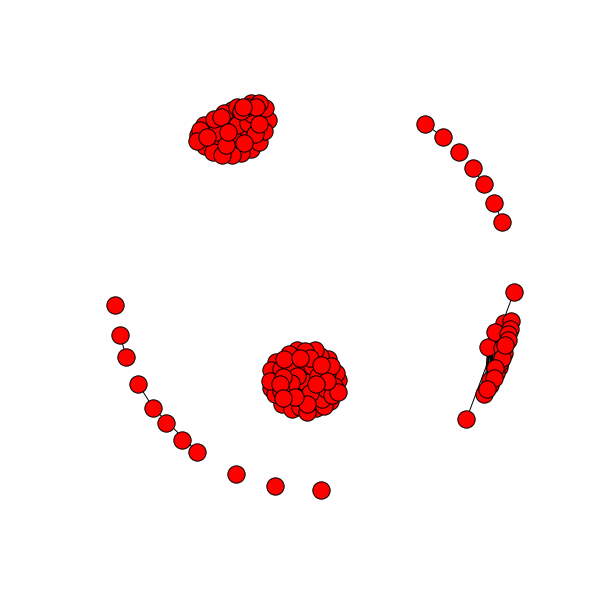

In [5]:
fig = figure(figsize=(10,10))  # NetworkX respects the current pylab figure/axes
ax = fig.add_subplot(1,1,1)
# k determines the distance between nodes, iterations controls rounds of layout
layout = nx.spring_layout(G, weight='identity', k=0.1, iterations=200)
nx.draw(G, pos=layout, ax=ax)

Visualising, and labelling the nodes using a dictionary, testing a number of layout options:

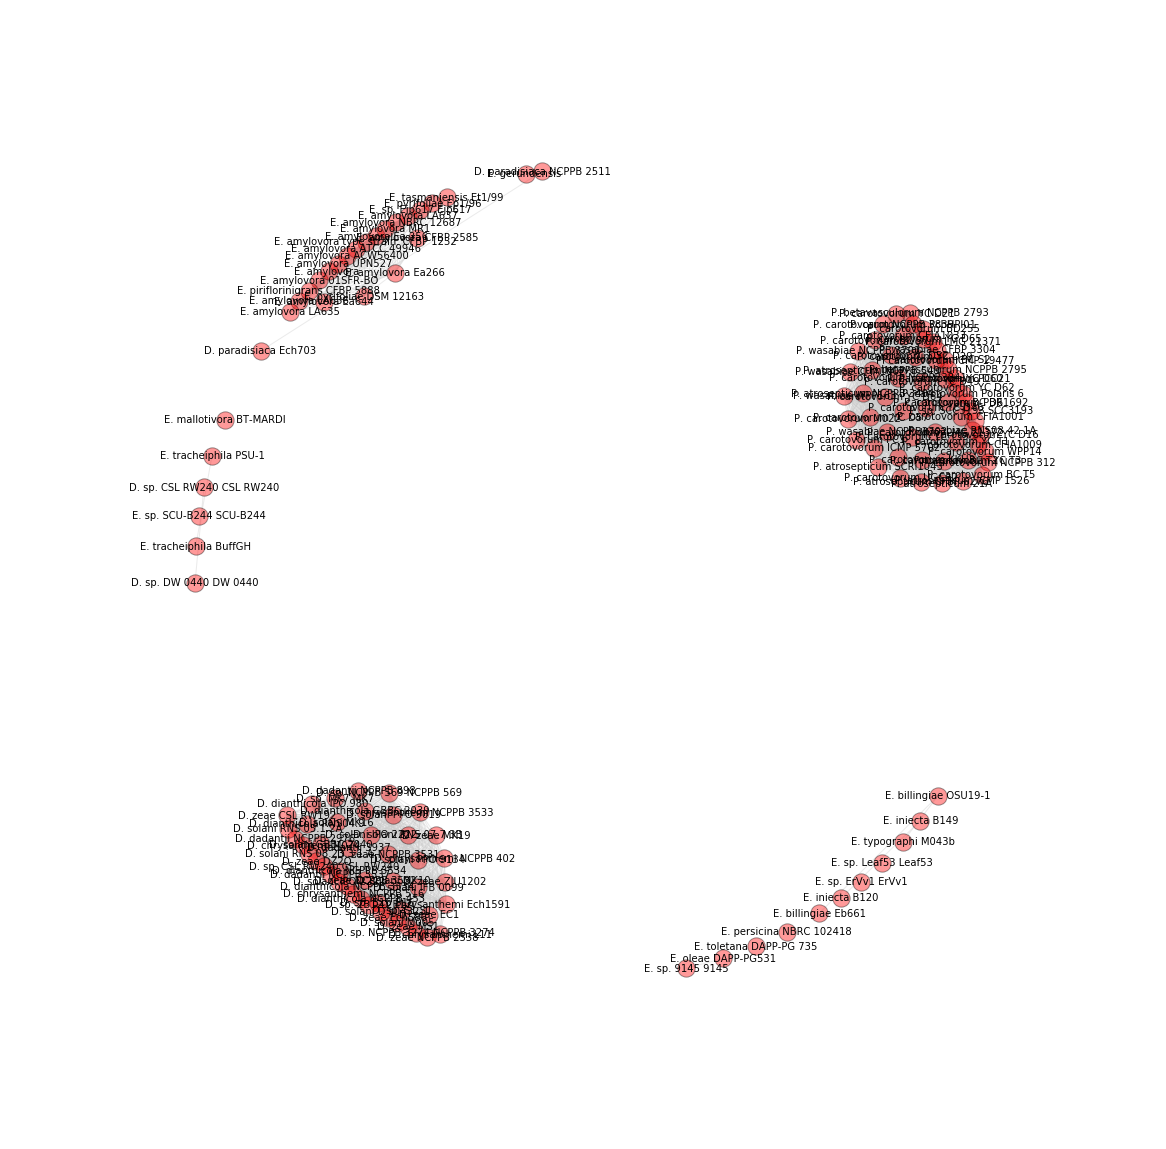

In [6]:
fig = figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)

# Try different weightings
weight = 'identity'
#weight = 'logident'
#weight = 'difference'

# Try different layouts
layout = nx.spring_layout(G, weight=weight, k=0.125, iterations=800)
#layout = nx.circular_layout(G)
#layout = nx.random_layout(G)
#layout = nx.shell_layout(G)
#layout = nx.spectral_layout(G, weight=weight, scale=2)

# Render
nx.draw(G, pos=layout, ax=ax, with_labels=True, labels=labeldict, alpha=0.4, font_size=10, edge_color="#cccccc")

### Functions to draw networks

In [7]:
def draw_network(graph, weight='identity', k=0.125, iterations=800, figsize=(20, 20)):
    fig, ax = subplots(figsize=figsize)
    layout = nx.spring_layout(graph, weight=weight, k=k, iterations=iterations)
    labels = {key: val for (key, val) in labeldict.items() if key in graph.nodes()}
    nx.draw(graph, pos=layout, ax=ax, with_labels=True, labels=labels,
            alpha=0.4, font_size=10, edge_color="#cccccc")

## Identifying natural groupings of isolates

By looking at the sizes of the connected component subgraphs (i.e. the individual disjoint graphs in the network) we can see how many different 'broad' classifications are supported by the data.

In [8]:
for SG in nx.connected_component_subgraphs(G):
    print("{0}\n{1}\n\n".format(len(SG.nodes()),
                                [labeldict[n] if n in labeldict else n
                                 for n in SG.nodes_iter()]))

57
['P. carotovorum BC S7', 'P. carotovorum CFIA1033', 'P. carotovorum WPP14', 'P. carotovorum YC D62', 'P. atrosepticum SCRI1043', 'P. carotovorum LMG 21371', 'P. carotovorum YC D57', 'P. carotovorum PC1', 'P. wasabiae RNS08.42.1A', 'GCA_000749915.1_ASM74991v1_genomic', 'P. carotovorum YC D52', 'P. carotovorum Polaris 6', 'P. carotovorum YC D46', 'P. atrosepticum NCPPB 3404', 'P. carotovorum PBR1692', 'P. carotovorum CFIA1001', 'P. atrosepticum 21A', 'P. carotovorum YC D64', 'P. wasabiae WPP163', 'P. carotovorum LMG 21372', 'P. carotovorum YC D16', 'P. carotovorum NCPPB 3839', 'GCA_000808295.1_ASM80829v1_genomic', 'P. atrosepticum CFBP 6276', 'P. carotovorum NCPPB3841', 'P. wasabiae NCPPB3702', 'P. carotovorum YC T1', 'P. betavasculorum NCPPB 2793', 'P. carotovorum KKH3', 'P. carotovorum M022', 'P. sp. SCC3193 SCC3193', 'P. carotovorum BD255', 'P. carotovorum UGC32', 'P. wasabiae NCPPB 3701', 'P. carotovorum BC T5', 'P. carotovorum ICMP 19477', 'P. carotovorum YC T39', 'P. atrosepticu

*Cliques* are completely-connected subgraphs, and represent internal groupings of isolates.

In [9]:
cliques = list(nx.find_cliques(G))
for c in cliques:
    print("{0}\n{1}\n\n".format(len(c),
                                [labeldict[n] if n in labeldict else n
                                 for n in c]))

46
['D. zeae Ech586', 'D. solani GBBC 2040', 'D. dianthicola IPO 980', 'D. sp. 2B12 2B12', 'D. chrysanthemi Ech1591', 'D. dianthicola NCPPB 3534', 'D. sp. NCPPB 3274 NCPPB 3274', 'D. zeae MK19', 'D. zeae NCPPB 2538', 'D. dadantii NCPPB 2976', 'D. dadantii NCPPB 3537', 'D. zeae EC1', 'D. solani M005', 'D. dianthicola NCPPB 3534', 'D. sp. NCPPB 569 NCPPB 569', 'D. zeae DZ2Q', 'D. sp. B16 B16', 'D. solani PPO 9134', 'D. dianthicola GBBC 2039', 'D. chrysanthemi M074', 'D. zeae ZJU1202', 'D. sp. MK7 MK7', 'D. chrysanthemi NCPPB 3533', 'D. solani RNS 08.23.3.1.A', 'D. solani IFB 0099', 'D. zeae CSL RW192', 'D. dadantii 3937', 'D. solani D s0432-1', 'D. solani RNS 07.7.3B', 'D. zeae NCPPB 3531', 'D. sp. S1 S1', 'D. dianthicola NCPPB 453', 'D. dadantii NCPPB 898', 'D. solani IPO 2222', 'D. zeae MS1', 'D. chrysanthemi NCPPB 402', 'D. solani PPO 9019', 'D. solani MK16', 'D. solani RNS 05.1.2A', 'D. zeae NCPPB 3532', 'D. chrysanthemi L11', 'D. chrysanthemi NCPPB 516', 'D. solani MK10', 'D. solani

If the total size of the cliques is equal to the total number of nodes in the network, then we have a self-consistent classification of isolates into mutually-supporting groups.

In [10]:
print("Network size: {0}, Number of cliques: {1}, Total clique size: {2}".format(len(G),
                                                                                  len(cliques),
                                                                                  sum([len(c) for c in cliques])))

Network size: 143, Number of cliques: 17, Total clique size: 144


It is possible that one or more nodes may participate in one or more cliques. The biological interpretation of this is as yet unclear, but it might indicate that there is a significant chimeric property/LGT between two or more subgroups of isolates.

There is an interesting property of this clique-based classification. Once a clique is identified then, so long as the genome iteself is not modified (i.e. draft assembly completed), the clique is *permanent*. The addition of new genomes/sequences can only extend the clique, not replace it. Cliques can then be considered as intersecting surfaces, where the clique defines the surface, and individual organisms present in several cliques represent *intersections* between those surfaces. Multiple surfaces may intersect at the same point.

For a set of genomes, with a given coverage/identity threshold, the difference between the number of nodes, and the total size of cliques, is reflective of the number of intersections, and may inidicate recombination, or that the classification does not fall along *natural boundaries*. This suggests an approach where the total clique size can be inspected as one or more thresholds increases, and fluctuations observed: *minima* on this path indicate natural groupings of the genomes.

I may have a mathematical answer for David Baltrus' suggestion of a universal whole genome classification scheme.

### Functions for identification of cliques/subgraphs

In [11]:
def count_cliques(graph):
    cliques = list(nx.find_cliques(graph))
    clique_size = sum([len(c) for c in cliques])
    subgraphs = list(nx.connected_component_subgraphs(graph))
    return(len(graph), len(subgraphs), len(cliques), clique_size)

def print_cliques(graph):
    cliques = list(nx.find_cliques(graph))
    print("Network size: {0}, Subgraphs: {1}, Number of cliques: {2}, Total clique size: {3}".format(*count_cliques(graph)))
    for c in cliques:
        print("{0}\n{1}\n\n".format(len(c),
                                    [labeldict[n] if n in labeldict else n
                                     for n in c]))
        


### Increasing thresholds

What happens if we increase the requirement for percentage coverage to be greater than 90% of the total genome length?

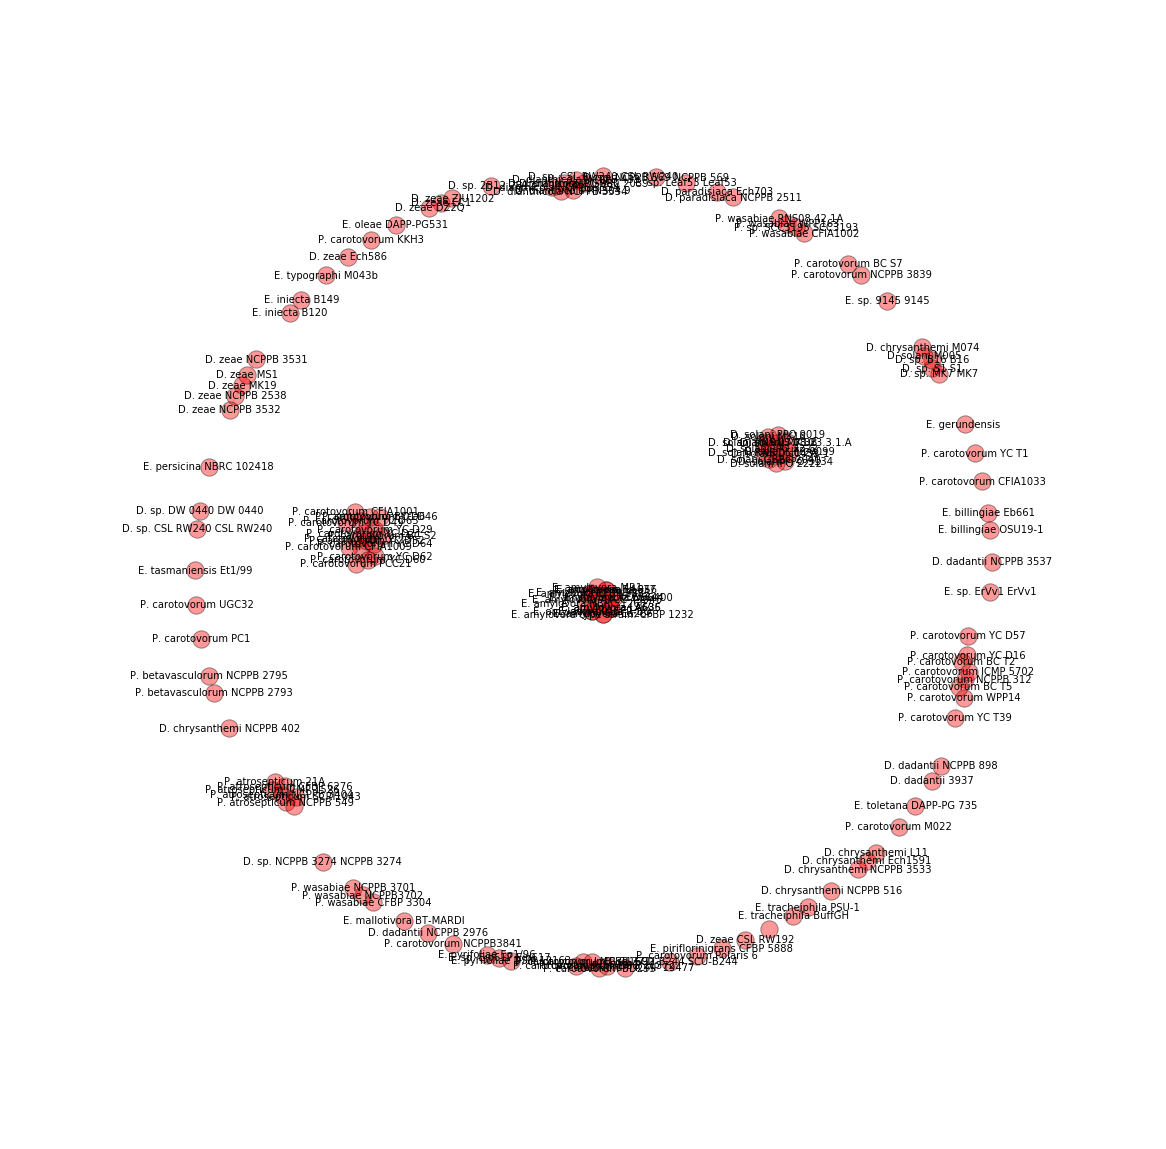

In [12]:
# Create graph
H = nx.Graph()

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    H.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(H,), cov_thresh=0.9)

# Draw network
fig, ax = subplots(figsize=(20,20))
layout = nx.spring_layout(H, weight=weight, k=0.025, iterations=800)
nx.draw(H, pos=layout, ax=ax, with_labels=True, labels=labeldict, alpha=0.4, font_size=10, edge_color="#cccccc")

Looking at the graph, we can see that there is separation into subgraphs that appear to correspond to natural species groupings.

In [13]:
print_cliques(H)

Network size: 143, Subgraphs: 52, Number of cliques: 76, Total clique size: 247
1
['D. zeae Ech586']


1
['D. sp. 2B12 2B12']


5
['P. carotovorum LMG 21371', 'P. carotovorum PBR1692', 'P. carotovorum PcbHPI01', 'P. carotovorum LMG 21372', 'P. carotovorum BD255']


1
['E. mallotivora BT-MARDI']


1
['P. carotovorum PC1']


15
['E. amylovora LA636', 'E. amylovora Ea644', 'E. amylovora UPN527', 'E. amylovora ACW56400', 'E. amylovora LA637', 'E. amylovora type strain: CFBP 1232', 'E. amylovora NBRC 12687', 'E. amylovora Ea266', 'E. amylovora Ea 356', 'E. amylovora CFBP 2585', 'E. amylovora ATCC 49946', 'E. amylovora ', 'E. amylovora MR1', 'E. amylovora LA635', 'E. amylovora 01SFR-BO']


1
['D. sp. NCPPB 3274 NCPPB 3274']


6
['D. dianthicola NCPPB 3534', 'D. dianthicola IPO 980', 'D. dianthicola NCPPB 453', 'D. dianthicola GBBC 2039', 'D. dianthicola RNS04.9', 'D. dianthicola NCPPB 3534']


2
['D. zeae MK19', 'D. zeae NCPPB 3531']


3
['D. zeae MK19', 'D. zeae NCPPB 2538', 'D. zeae MS1']


Inspection of the cliques at this threshold however shows that there's quite a bit of confusion within those groupings, that stems from the different edge weights - not all the internal groupings are equally well-connected. 

What happens if we require that percentage identity also needs to be over 99%?

In [14]:
# Remove edges from the network if percentage identity is less than 99%
edgelist = H.edges(data='identity')
for e in edgelist:
    if e[-1] < 0.95:
        H.remove_edge(e[0], e[1])

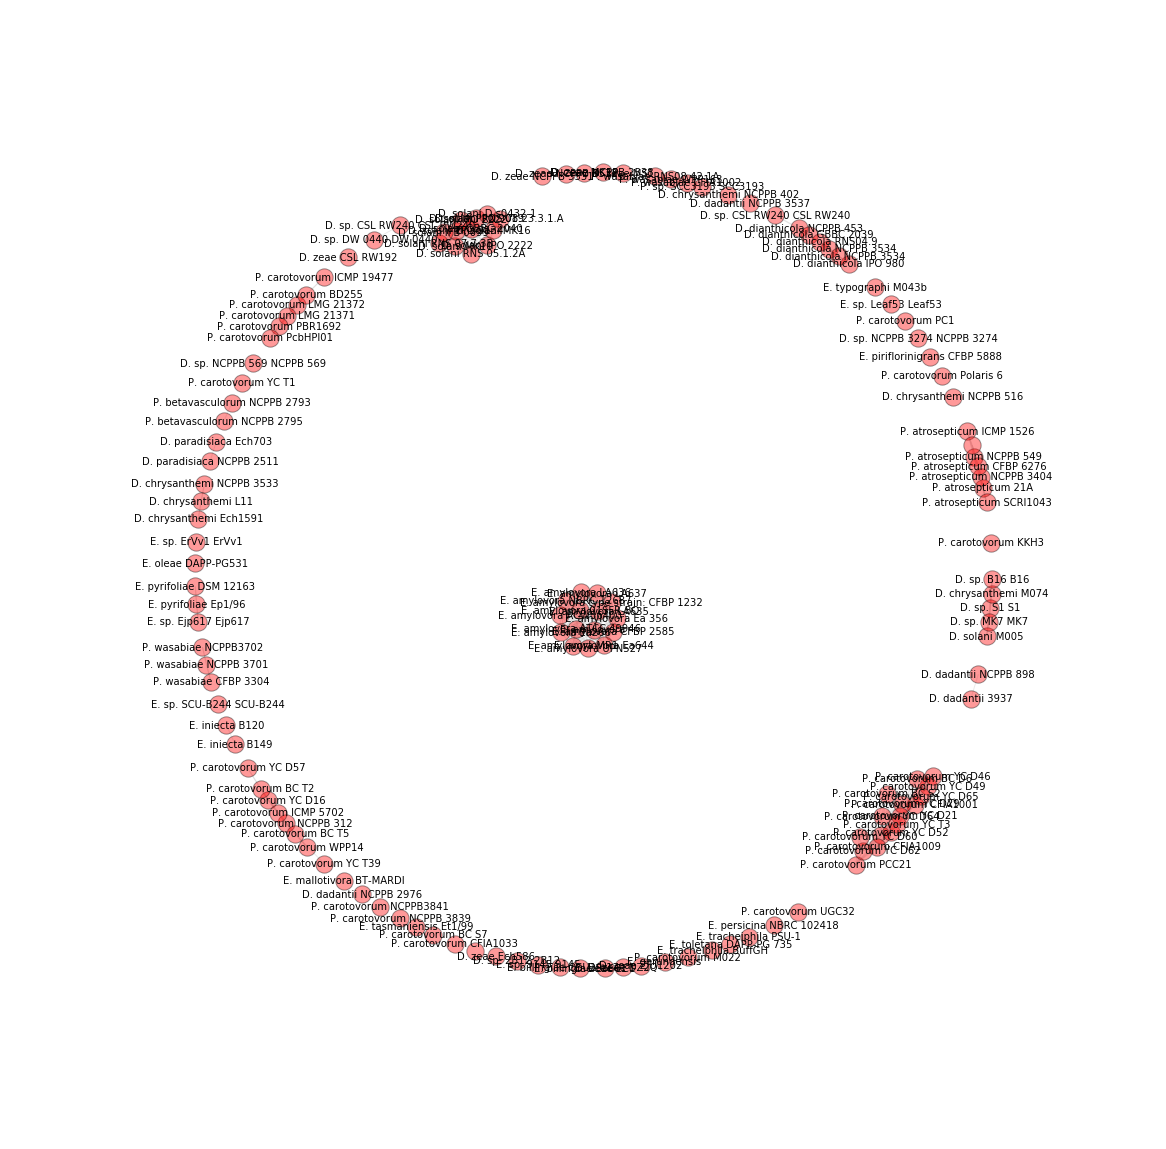

In [15]:
draw_network(H, k=0.05)

In [16]:
print_cliques(H)

Network size: 143, Subgraphs: 52, Number of cliques: 76, Total clique size: 247
1
['D. zeae Ech586']


1
['D. sp. 2B12 2B12']


5
['P. carotovorum LMG 21371', 'P. carotovorum PBR1692', 'P. carotovorum PcbHPI01', 'P. carotovorum LMG 21372', 'P. carotovorum BD255']


1
['E. mallotivora BT-MARDI']


1
['P. carotovorum PC1']


15
['E. amylovora LA636', 'E. amylovora Ea644', 'E. amylovora UPN527', 'E. amylovora ACW56400', 'E. amylovora LA637', 'E. amylovora type strain: CFBP 1232', 'E. amylovora NBRC 12687', 'E. amylovora Ea266', 'E. amylovora Ea 356', 'E. amylovora CFBP 2585', 'E. amylovora ATCC 49946', 'E. amylovora ', 'E. amylovora MR1', 'E. amylovora LA635', 'E. amylovora 01SFR-BO']


1
['D. sp. NCPPB 3274 NCPPB 3274']


6
['D. dianthicola NCPPB 3534', 'D. dianthicola IPO 980', 'D. dianthicola NCPPB 453', 'D. dianthicola GBBC 2039', 'D. dianthicola RNS04.9', 'D. dianthicola NCPPB 3534']


2
['D. zeae MK19', 'D. zeae NCPPB 3531']


3
['D. zeae MK19', 'D. zeae NCPPB 2538', 'D. zeae MS1']


There seems to have been no change. So what if we increase to 99.9% identity threshold?

In [17]:
edgelist = H.edges(data='identity')
for e in edgelist:
    if e[-1] < 0.999:
        H.remove_edge(e[0], e[1])

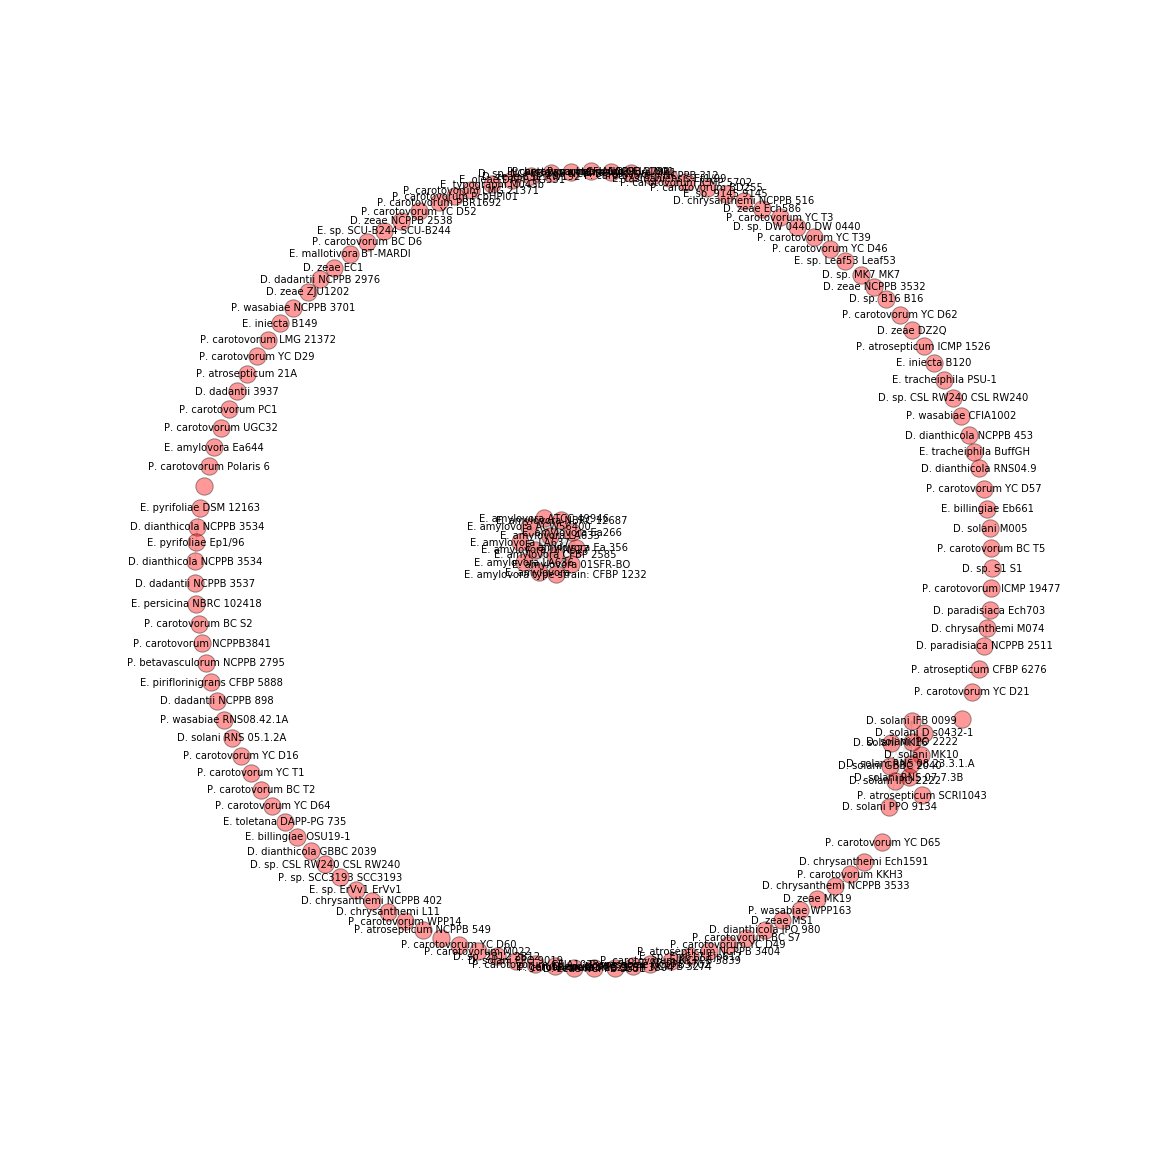

In [18]:
draw_network(H, k=0.05)

In [19]:
print_cliques(H)

Network size: 143, Subgraphs: 110, Number of cliques: 112, Total clique size: 154
1
['D. zeae Ech586']


1
['D. sp. 2B12 2B12']


3
['P. carotovorum LMG 21371', 'P. carotovorum PBR1692', 'P. carotovorum PcbHPI01']


1
['E. mallotivora BT-MARDI']


1
['P. carotovorum PC1']


13
['E. amylovora LA636', 'E. amylovora UPN527', 'E. amylovora ACW56400', 'E. amylovora LA637', 'E. amylovora type strain: CFBP 1232', 'E. amylovora NBRC 12687', 'E. amylovora Ea266', 'E. amylovora Ea 356', 'E. amylovora ATCC 49946', 'E. amylovora ', 'E. amylovora CFBP 2585', 'E. amylovora LA635', 'E. amylovora 01SFR-BO']


1
['D. sp. NCPPB 3274 NCPPB 3274']


2
['D. dianthicola NCPPB 3534', 'D. dianthicola NCPPB 3534']


1
['D. zeae MK19']


1
['E. sp. 9145 9145']


1
['D. sp. NCPPB 569 NCPPB 569']


5
['D. solani PPO 9134', 'D. solani GBBC 2040', 'D. solani MK10', 'D. solani IPO 2222', 'D. solani RNS 08.23.3.1.A']


2
['D. chrysanthemi NCPPB 3533', 'D. chrysanthemi Ech1591']


1
['GCA_000808295.1_ASM80829v1_genomi

There's a great deal of fragmentation of the network - 110 subgraphs, with lots of singletons.

### Functions to check thresholds

In [20]:
def trim_graph(graph, threshold, data='identity'):
    edgelist = graph.edges(data=data)
    for e in edgelist:
        if e[-1] < threshold:
            graph.remove_edge(e[0], e[1])
    return(graph)

### Change %identity threshold and watch clique size

What happens to the difference between total clique size and network size, as we increase %identity threshold?

In [21]:
# Create graph
J = nx.Graph()

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    J.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(J,), cov_thresh=0.5)

# Loop over thresholds from 0 to 100% identity, get difference in size
thresholds = linspace(0.85, 1, 1500)
row_list = []
for t in thresholds:
    J = trim_graph(J, t)
    netsize, sgsize, clqcount, clqsize = count_cliques(J)
    datadict = {'identity': t,
                'network_size': netsize,
                'subgraph_count': sgsize,
                'clique_count': clqcount,
                'total_clique_size': clqsize,
                'difference': clqsize-netsize}
    row_list.append(datadict)
threshold_profile = pd.DataFrame(row_list, columns=['identity', 'network_size',
                                                    'subgraph_count',
                                                    'clique_count', 'total_clique_size',
                                                    'difference'])

In [22]:
# Check the data looks sane
threshold_profile.head()

identity  network_size  subgraph_count  clique_count  total_clique_size  \
0    0.8500           143              16            17                144   
1    0.8501           143              16            17                144   
2    0.8502           143              16            17                144   
3    0.8503           143              16            17                144   
4    0.8504           143              16            17                144   

   difference  
0           1  
1           1  
2           1  
3           1  
4           1

#### Excess isolates in cliques

The excess of total number of isolates in cliques over the total number of isolates represents the count of isolates that are at *edges* or *intersections* between groups. A large excess indicates a difficulty in classifying those isolates uniquely. An excess of zero (or nearly zero) indicates that each isolate can be placed in exactly one mutually-supporting group, and may represent a natural clustering threshold for the dataset.

(0.85, 1)

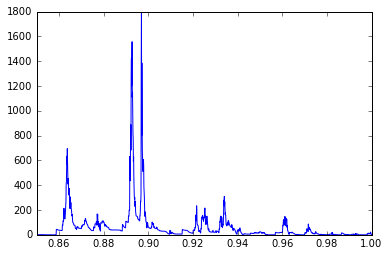

In [23]:
plot(threshold_profile['identity'], threshold_profile['difference'])
xlim(0.85, 1)

From the plot we see three major, and around eight minor peaks. The largest peaks are just short of 90% identity, and around 86% identity. There are smaller peaks at 92, 93 and 96% identity. It is tempting to see the peaks as indicating identity thresholds where there is much classification confusion.

It could be that the larger peaks indicate confusion at allocating distinct species or genus boundaries. The smaller peaks indicate confusion at allocating species or 'subspecies' boundaries.

There are noticable minima at around 91%, 95% and 98% identity. These may represent natural boundary minima that separate out genus and species well.

(0, 800)

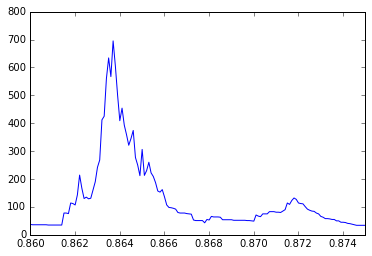

In [24]:
# The first large peak
plot(threshold_profile['identity'], threshold_profile['difference'])
xlim(0.86, 0.875)
ylim(0, 800)

Looking at the 0.864 peak:

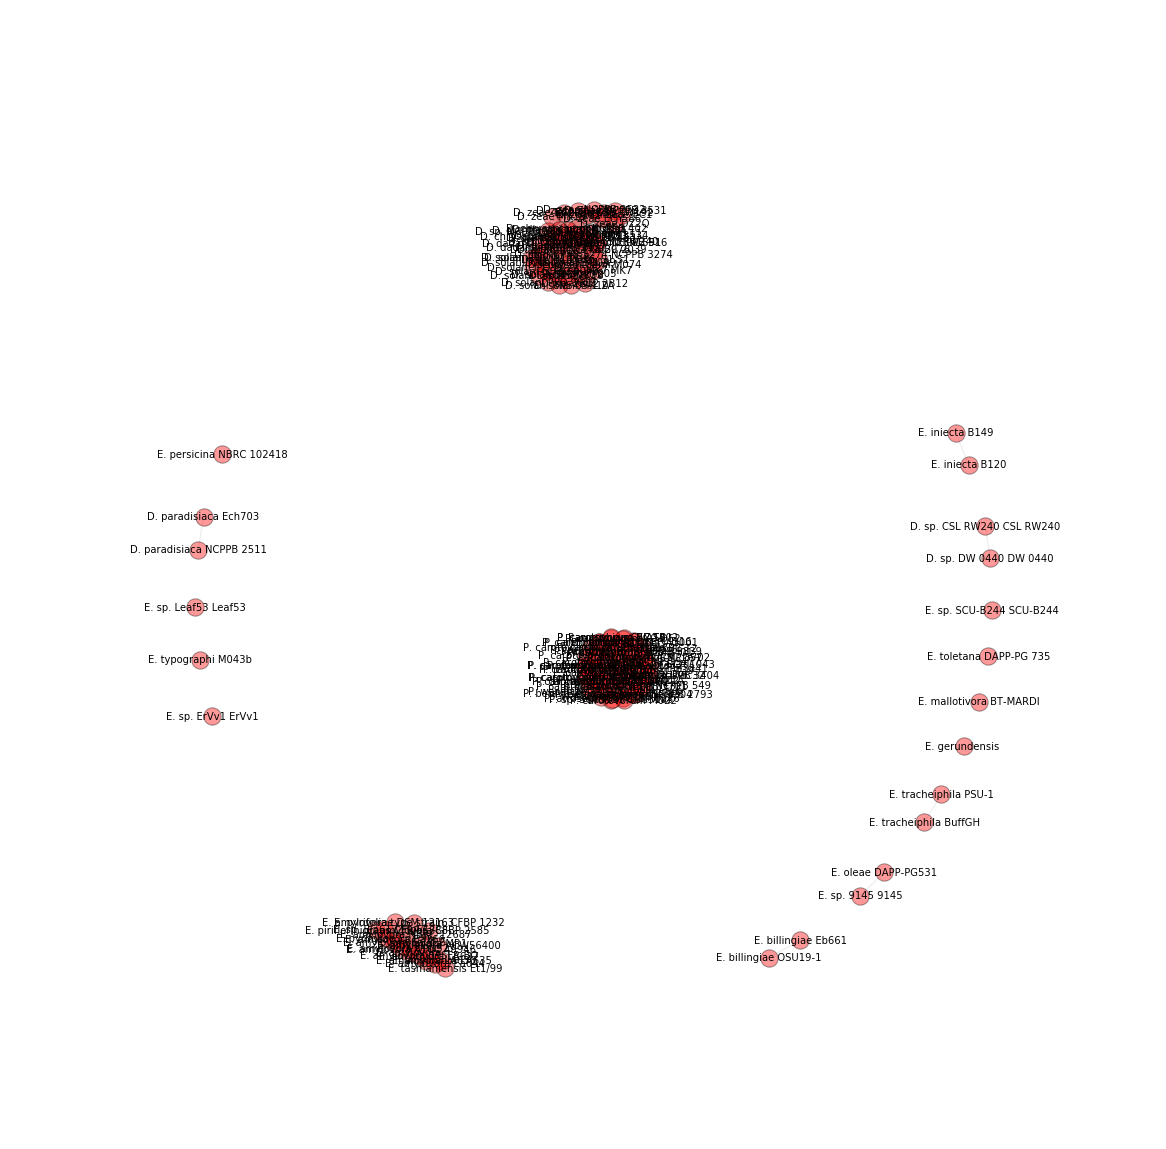

In [25]:
# Create graph
K = nx.Graph()

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    K.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(K,), cov_thresh=0.5)

# Trim to 0.864% identity
K = trim_graph(K, 0.864)

# Draw network
draw_network(K, k=0.05)

In [26]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 17, Number of cliques: 35, Total clique size: 533
22
['D. zeae Ech586', 'D. dianthicola IPO 980', 'D. chrysanthemi Ech1591', 'D. dianthicola NCPPB 3534', 'D. dianthicola NCPPB 3534', 'D. sp. NCPPB 569 NCPPB 569', 'D. dianthicola GBBC 2039', 'D. chrysanthemi NCPPB 3533', 'D. dianthicola NCPPB 453', 'D. chrysanthemi NCPPB 402', 'D. chrysanthemi L11', 'D. chrysanthemi NCPPB 516', 'D. dianthicola RNS04.9', 'D. sp. CSL RW240 CSL RW240', 'D. dadantii 3937', 'D. zeae NCPPB 3532', 'D. zeae MK19', 'D. zeae NCPPB 2538', 'D. zeae MS1', 'D. zeae CSL RW192', 'D. zeae EC1', 'D. zeae DZ2Q']


20
['D. zeae Ech586', 'D. dianthicola IPO 980', 'D. chrysanthemi Ech1591', 'D. dianthicola NCPPB 3534', 'D. dianthicola NCPPB 3534', 'D. sp. NCPPB 569 NCPPB 569', 'D. dianthicola GBBC 2039', 'D. chrysanthemi NCPPB 3533', 'D. dianthicola NCPPB 453', 'D. chrysanthemi NCPPB 402', 'D. chrysanthemi L11', 'D. chrysanthemi NCPPB 516', 'D. dianthicola RNS04.9', 'D. sp. CSL RW240 CSL RW240',

The graph and list of cliques indicate that the genus-level separation is good, but there are a large number of cliques within those clusters that apparently do not separate well between assigned species - mostly within *Dickeya*.

Moving up to the next minimum, at about 0.868:

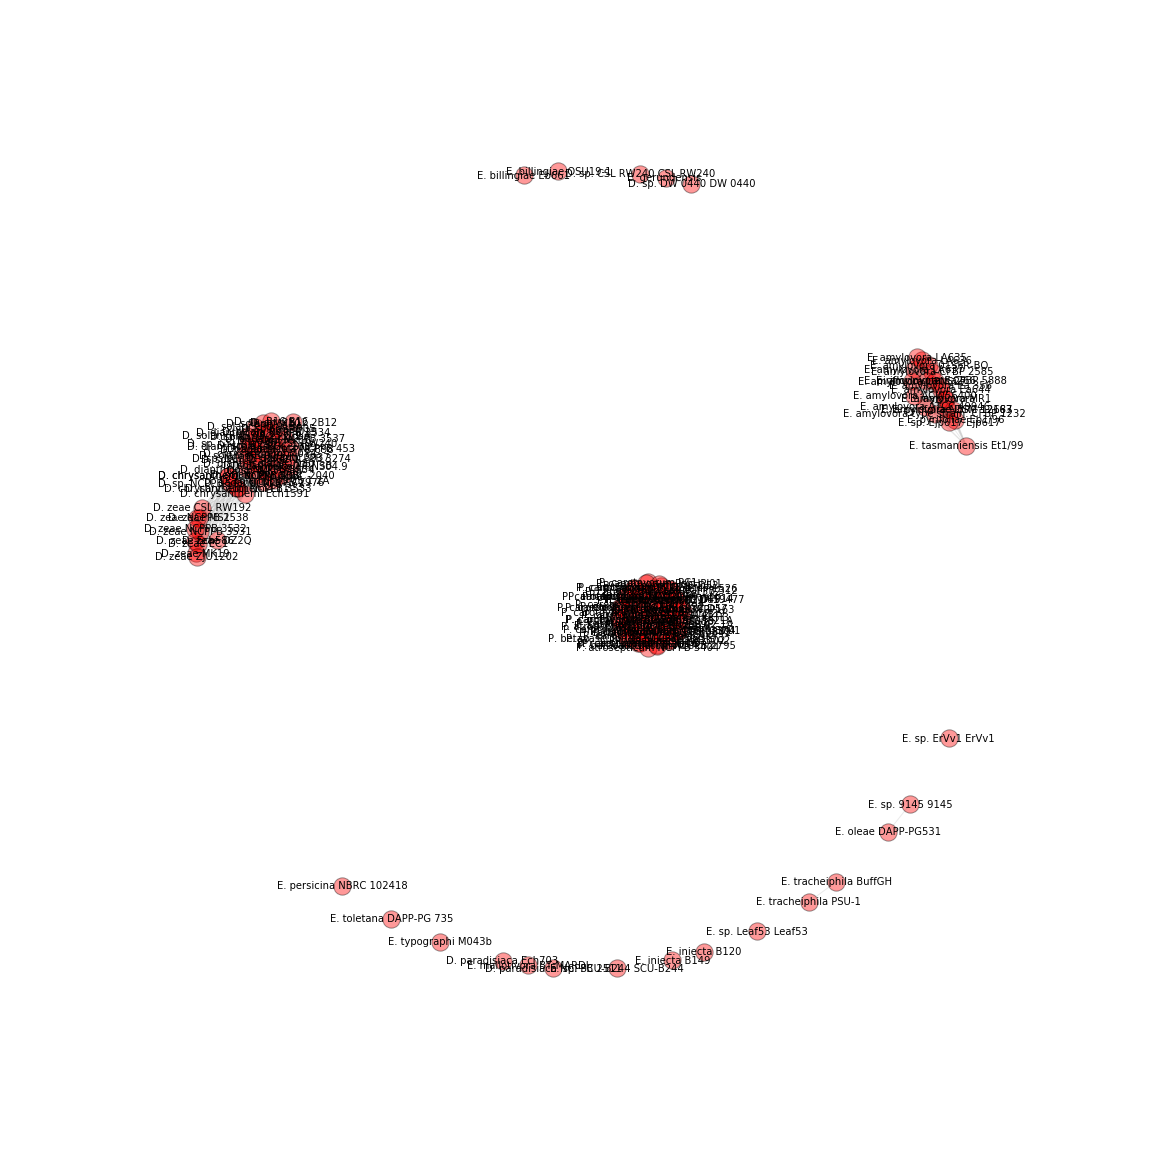

In [27]:
# Trim to 0.868% identity
K = trim_graph(K, 0.868)

# Draw network
draw_network(K, k=0.05)

In [28]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 17, Number of cliques: 21, Total clique size: 196
16
['D. zeae Ech586', 'D. zeae CSL RW192', 'D. zeae NCPPB 3531', 'D. sp. NCPPB 569 NCPPB 569', 'D. zeae DZ2Q', 'D. zeae ZJU1202', 'D. chrysanthemi Ech1591', 'D. chrysanthemi NCPPB 402', 'D. chrysanthemi NCPPB 3533', 'D. zeae NCPPB 3532', 'D. chrysanthemi L11', 'D. chrysanthemi NCPPB 516', 'D. zeae MS1', 'D. zeae MK19', 'D. zeae EC1', 'D. zeae NCPPB 2538']


30
['D. sp. 2B12 2B12', 'D. solani GBBC 2040', 'D. dianthicola IPO 980', 'D. dianthicola NCPPB 3534', 'D. sp. NCPPB 3274 NCPPB 3274', 'D. dadantii NCPPB 2976', 'D. dadantii NCPPB 3537', 'D. solani M005', 'D. dianthicola NCPPB 3534', 'D. dadantii 3937', 'D. solani D s0432-1', 'D. solani RNS 07.7.3B', 'D. sp. S1 S1', 'D. sp. B16 B16', 'D. solani PPO 9134', 'D. dianthicola NCPPB 453', 'D. dadantii NCPPB 898', 'D. dianthicola GBBC 2039', 'D. chrysanthemi M074', 'D. solani IPO 2222', 'D. sp. MK7 MK7', 'D. solani PPO 9019', 'D. solani MK16', 'D. solani RNS 05.

Now there are fewer cliques, especially for *Dickeya*, which appears to have settled out at a *Dch/Dze*:other *Dickeya* split, with some lingering connecting edges - apparent both from the graph and the clique list.

The really big peak is at around 0.893% identity, with the next minimum at around 0.914%

(0, 2000)

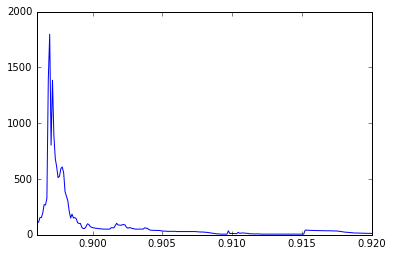

In [29]:
# The largest peak
plot(threshold_profile['identity'], threshold_profile['difference'])
xlim(0.896, 0.92)
ylim(0, 2000)

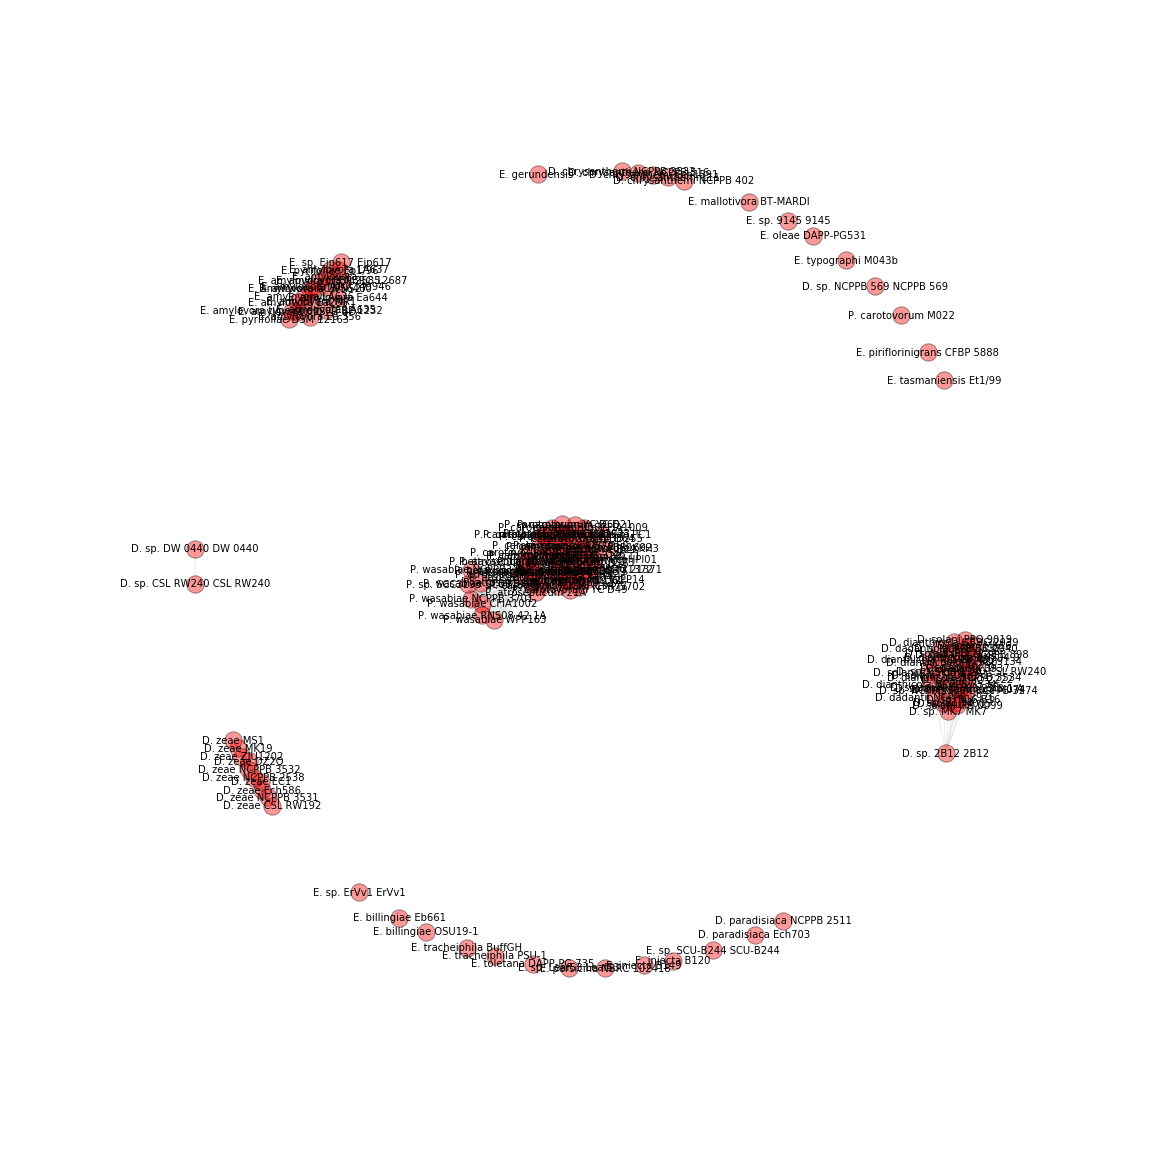

In [30]:
# Trim to 0.896% identity
K = trim_graph(K, 0.8966)

# Draw network
draw_network(K, k=0.05)

In [31]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 22, Number of cliques: 32, Total clique size: 453
10
['D. zeae Ech586', 'D. zeae CSL RW192', 'D. zeae NCPPB 3531', 'D. zeae DZ2Q', 'D. zeae ZJU1202', 'D. zeae MS1', 'D. zeae NCPPB 3532', 'D. zeae MK19', 'D. zeae EC1', 'D. zeae NCPPB 2538']


9
['D. sp. 2B12 2B12', 'D. sp. S1 S1', 'D. sp. B16 B16', 'D. chrysanthemi M074', 'D. sp. MK7 MK7', 'D. solani IFB 0099', 'D. sp. NCPPB 3274 NCPPB 3274', 'D. solani M005', 'D. dadantii NCPPB 2976']


1
['E. mallotivora BT-MARDI']


39
['P. carotovorum PC1', 'P. carotovorum BC S7', 'P. carotovorum CFIA1033', 'P. carotovorum WPP14', 'P. carotovorum YC D62', 'P. carotovorum CFIA1001', 'P. carotovorum LMG 21371', 'P. carotovorum PCC21', 'P. carotovorum ICMP 5702', 'GCA_000749915.1_ASM74991v1_genomic', 'P. carotovorum YC D52', 'P. carotovorum Polaris 6', 'P. carotovorum YC D46', 'P. carotovorum PBR1692', 'P. carotovorum YC D64', 'P. carotovorum LMG 21372', 'P. carotovorum YC D16', 'P. carotovorum NCPPB 3839', 'P. carotovorum

At the large peak, we seem to have hit a threshold of indecision for *Pectobacterium* spp. - which seem to take up most of the overlapping cliques. *P. wasabiae* looks to be well split-off from the the other *Pectobacteria*, but there's quite a bit of confusion among the other species.

At the next minimum:

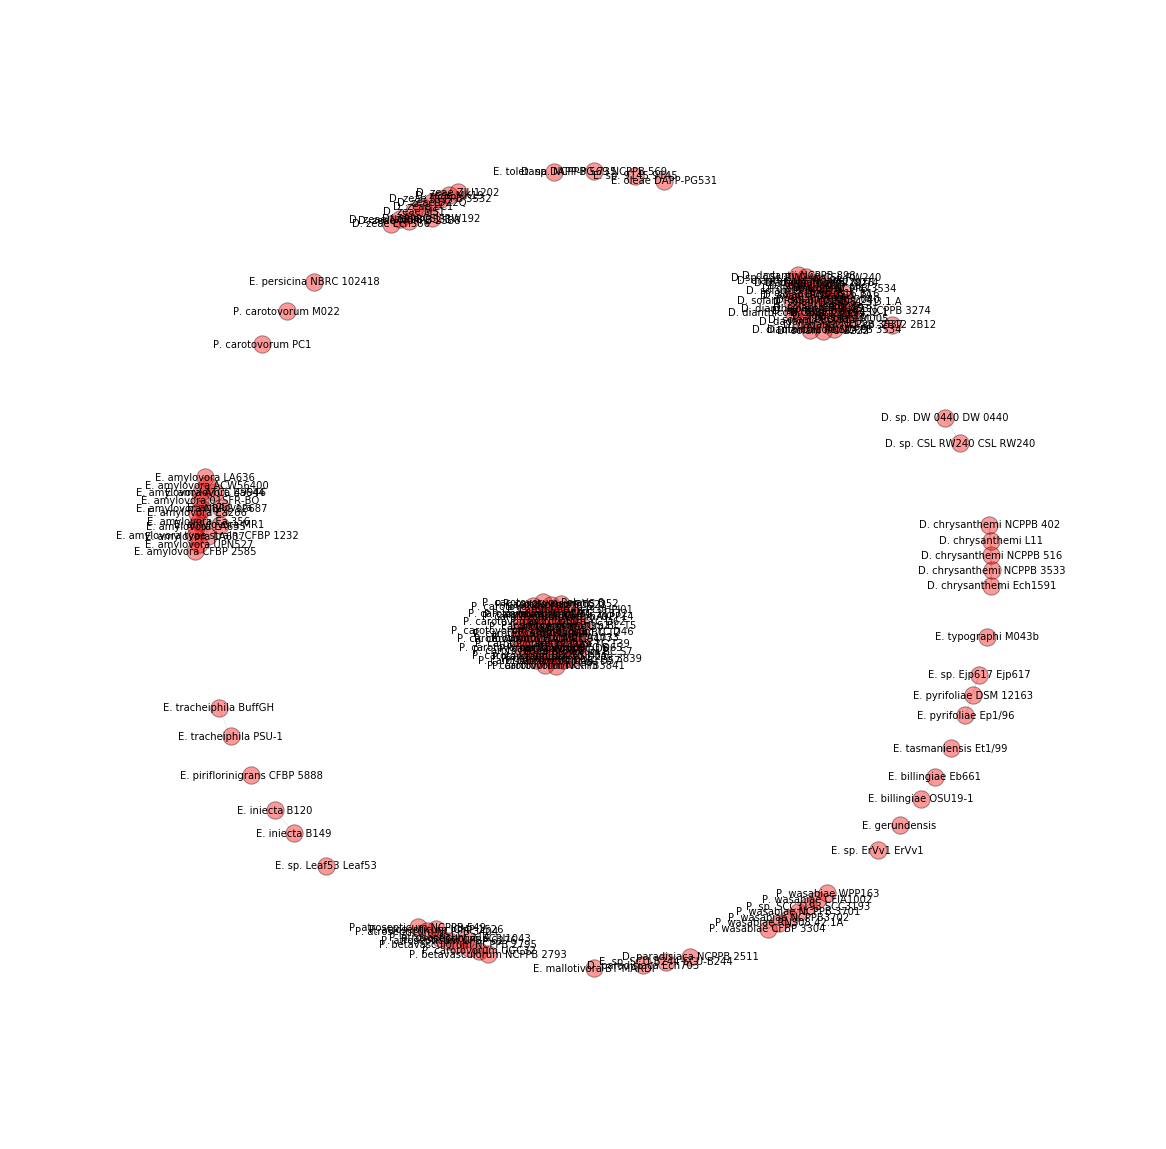

In [32]:
# Trim to 0.914% identity
K = trim_graph(K, 0.914)

# Draw network
draw_network(K, k=0.05)

In [33]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 27, Number of cliques: 28, Total clique size: 149
10
['D. zeae Ech586', 'D. zeae CSL RW192', 'D. zeae NCPPB 3531', 'D. zeae DZ2Q', 'D. zeae ZJU1202', 'D. zeae MS1', 'D. zeae NCPPB 3532', 'D. zeae MK19', 'D. zeae EC1', 'D. zeae NCPPB 2538']


7
['D. sp. 2B12 2B12', 'D. sp. S1 S1', 'D. sp. MK7 MK7', 'D. sp. B16 B16', 'D. sp. NCPPB 3274 NCPPB 3274', 'D. chrysanthemi M074', 'D. solani M005']


38
['P. carotovorum LMG 21371', 'P. carotovorum BC S7', 'P. carotovorum CFIA1033', 'P. carotovorum WPP14', 'P. carotovorum YC D62', 'P. carotovorum CFIA1001', 'P. carotovorum PCC21', 'P. carotovorum ICMP 5702', 'GCA_000749915.1_ASM74991v1_genomic', 'P. carotovorum YC D52', 'P. carotovorum Polaris 6', 'P. carotovorum YC D46', 'P. carotovorum PBR1692', 'P. carotovorum YC D64', 'P. carotovorum LMG 21372', 'P. carotovorum YC D16', 'P. carotovorum NCPPB 3839', 'P. carotovorum YC T1', 'P. carotovorum NCPPB 312', 'P. carotovorum KKH3', 'P. carotovorum BC T2', 'P. carotovorum YC

There is only a small amount of confusion - the isolates are well-separated into groups, but not in a way that matches the assigned species names (for the most part). Some species are well separated into cliques, such as:

* *P. carotovorum*
* *E. amylovora*
* *D. zeae*
* *P. wasabiae*
* *D. chrysanthemi*
* *D. paradisiaca*

but, at this point, most *Dickeya* spp. are still lumped together, and there's not clear disconnection between *P. betavasculorum* and *P. atrosepticum*.

Moving on to one of the later peaks, at 93.4% identity, with corresponding minimum at 0.955:

(0, 350)

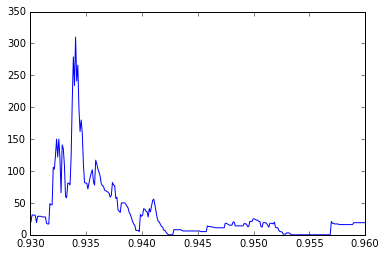

In [34]:
# A species boundary peak?
plot(threshold_profile['identity'], threshold_profile['difference'])
xlim(0.93, 0.96)
ylim(0, 350)

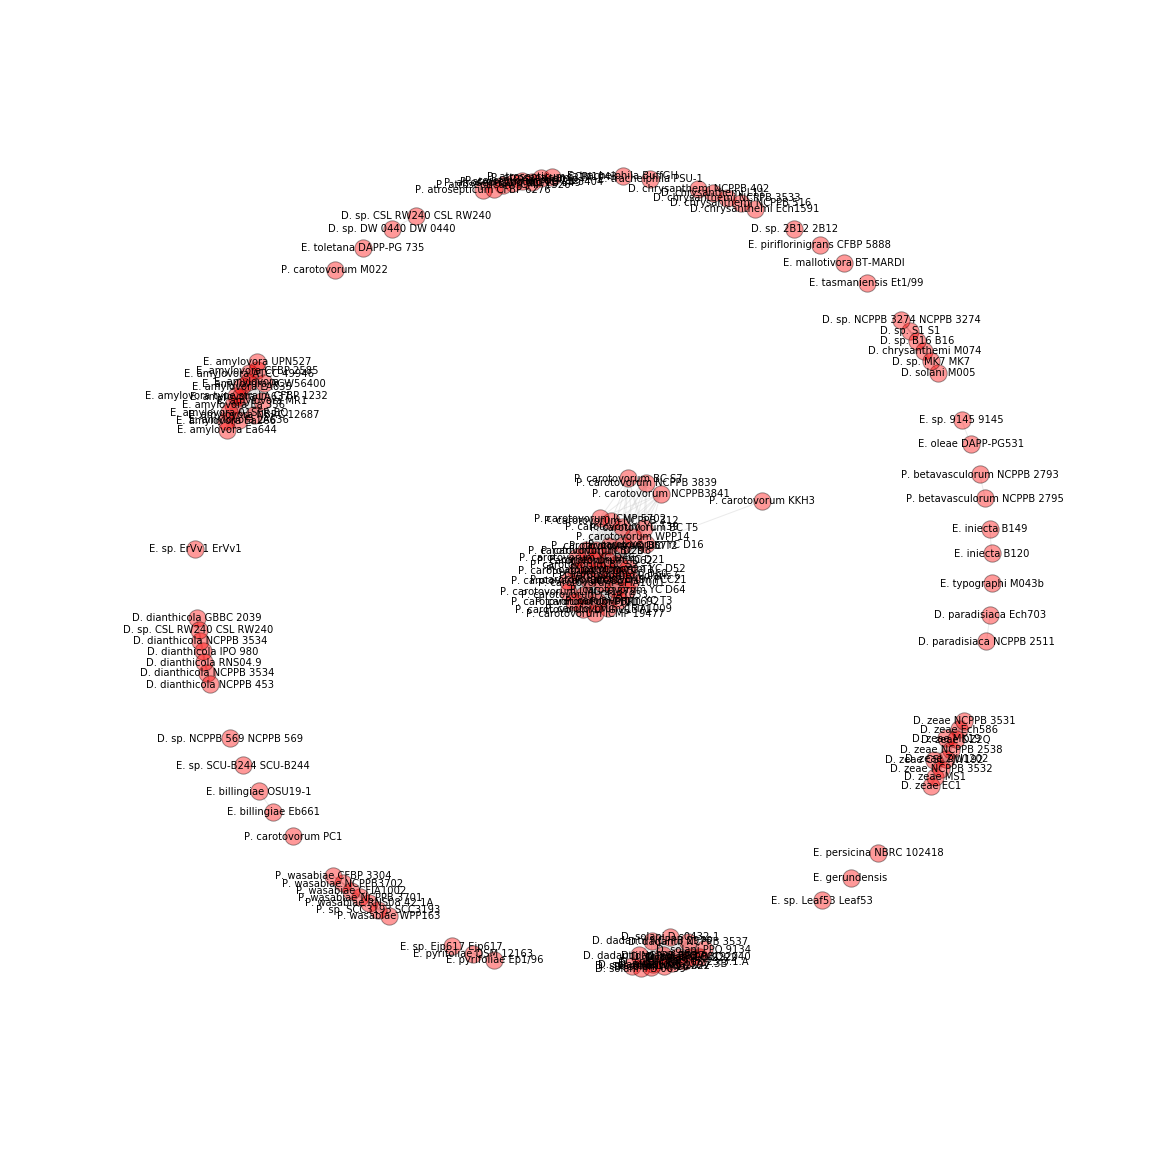

In [35]:
# Trim to 0.934 identity
K = trim_graph(K, 0.934)

# Draw network
draw_network(K, k=0.05)

In [36]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 31, Number of cliques: 49, Total clique size: 455
10
['D. zeae Ech586', 'D. zeae CSL RW192', 'D. zeae NCPPB 3531', 'D. zeae DZ2Q', 'D. zeae ZJU1202', 'D. zeae MS1', 'D. zeae NCPPB 3532', 'D. zeae MK19', 'D. zeae EC1', 'D. zeae NCPPB 2538']


1
['D. sp. 2B12 2B12']


1
['E. mallotivora BT-MARDI']


1
['P. carotovorum PC1']


15
['E. amylovora LA636', 'E. amylovora Ea644', 'E. amylovora UPN527', 'E. amylovora ACW56400', 'E. amylovora LA637', 'E. amylovora type strain: CFBP 1232', 'E. amylovora NBRC 12687', 'E. amylovora Ea266', 'E. amylovora Ea 356', 'E. amylovora CFBP 2585', 'E. amylovora ATCC 49946', 'E. amylovora ', 'E. amylovora MR1', 'E. amylovora LA635', 'E. amylovora 01SFR-BO']


6
['D. sp. NCPPB 3274 NCPPB 3274', 'D. sp. MK7 MK7', 'D. sp. S1 S1', 'D. sp. B16 B16', 'D. chrysanthemi M074', 'D. solani M005']


7
['D. dianthicola NCPPB 3534', 'D. dianthicola IPO 980', 'D. dianthicola NCPPB 453', 'D. dianthicola GBBC 2039', 'D. dianthicola RNS04.9', 'D. d

We still have the large genus-level groupings, but now there are several points of confusion within the *P. carotovorum* cluster, leading to several cliques with overlapping membership. 

As we approach the minimum at 0.955:

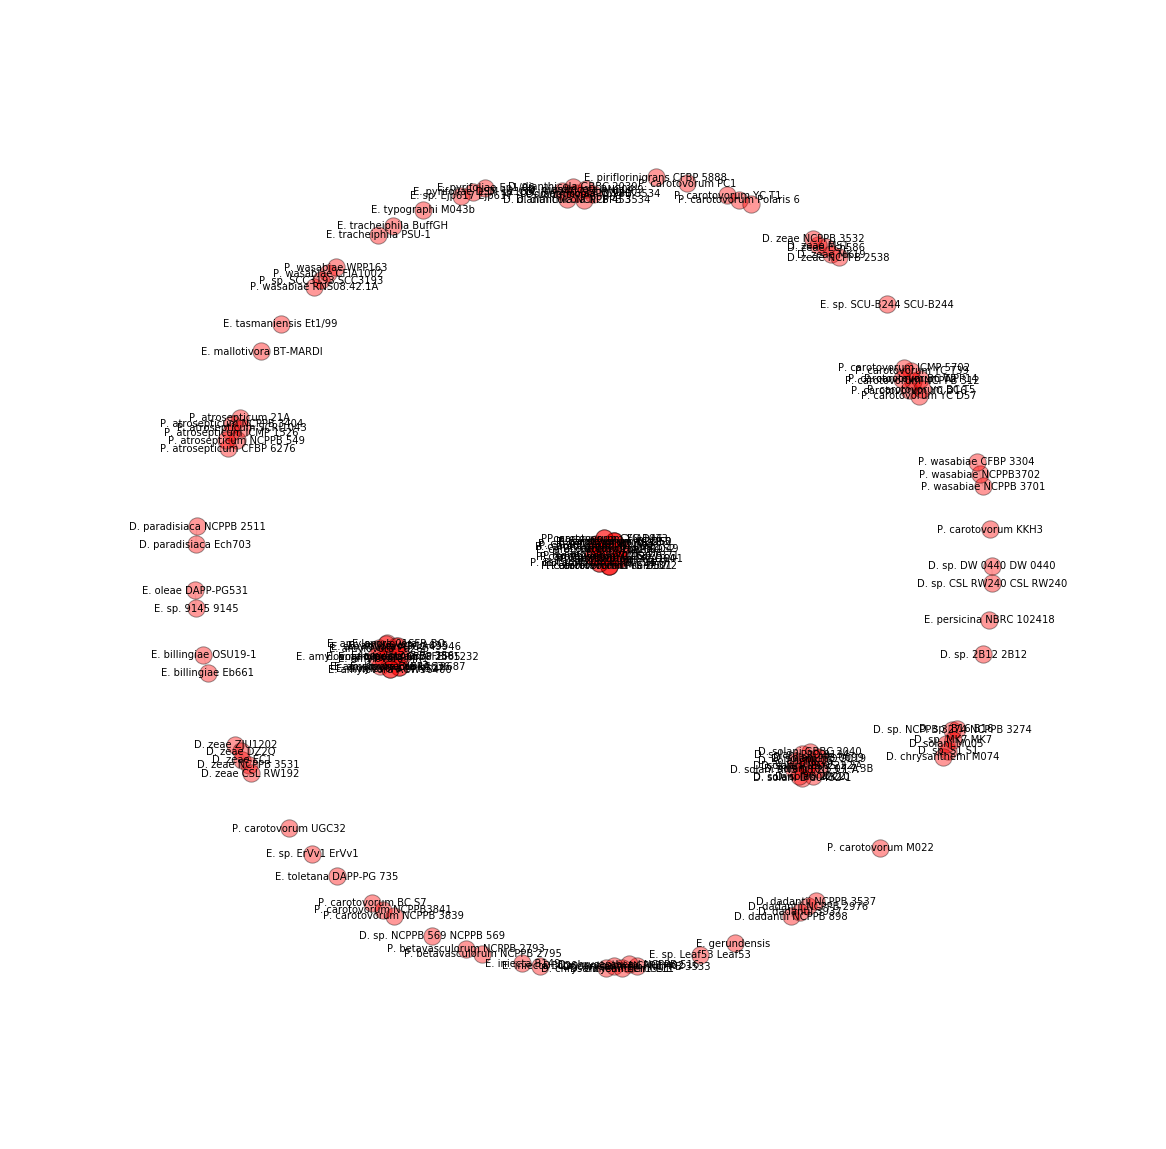

In [37]:
# Trim to 0.955 identity
K = trim_graph(K, 0.955)

# Draw network
draw_network(K, k=0.025)

In [38]:
# What are the cliques?
print_cliques(K)

Network size: 143, Subgraphs: 39, Number of cliques: 39, Total clique size: 143
5
['D. zeae Ech586', 'D. zeae MS1', 'D. zeae NCPPB 3532', 'D. zeae MK19', 'D. zeae NCPPB 2538']


1
['D. sp. 2B12 2B12']


23
['P. carotovorum LMG 21371', 'P. carotovorum CFIA1033', 'P. carotovorum PBR1692', 'P. carotovorum YC T3', 'P. carotovorum YC D62', 'P. carotovorum BD255', 'P. carotovorum CFIA1001', 'P. carotovorum YC D64', 'P. carotovorum YC D60', 'P. carotovorum LMG 21372', 'P. carotovorum PCC21', 'P. carotovorum ICMP 19477', 'P. carotovorum YC D52', 'P. carotovorum YC D49', 'GCA_000808295.1_ASM80829v1_genomic', 'P. carotovorum PcbHPI01', 'P. carotovorum CFIA1009', 'P. carotovorum YC D21', 'P. carotovorum YC D29', 'P. carotovorum BC D6', 'P. carotovorum YC D65', 'P. carotovorum YC D46', 'P. carotovorum BC S2']


1
['E. mallotivora BT-MARDI']


1
['P. carotovorum PC1']


15
['E. amylovora LA636', 'E. amylovora Ea644', 'E. amylovora UPN527', 'E. amylovora ACW56400', 'E. amylovora LA637', 'E. amylovor

We have a 'perfect' assignment of isolates to cliques/subgraphs, that has split the *P. carotovorum* subgroup into five distinct mutually-supporting cliques. 

We can look at the individual subgraphs, below.

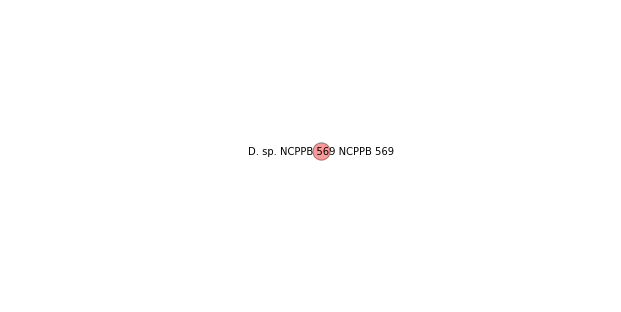

In [39]:
# Get subgraphs
subgraphs = list(nx.connected_component_subgraphs(K))

# Draw a single subgraph
draw_network(subgraphs[13], figsize=(10, 5))

## Clique count and subgraph count

Plotting the variation in clique count (as opposed to total clique members) with percentage identity, a clear trand is notable:

(0.85, 1)

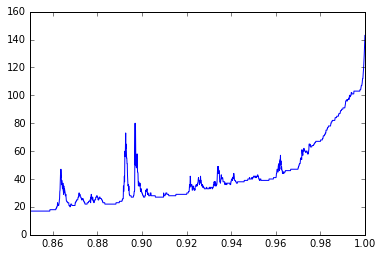

In [40]:
plot(threshold_profile['identity'], threshold_profile['clique_count'])
xlim(0.85, 1)

This is a similar 'spiky' plot to the total number of clique members, but overlaid on a baseline that increases gradually at first (up to about 97% identity), and then rapidly from that point.

This baseline is, essentially, the subgraph count. As cliques cannot span subgraphs, there must be at least as many cliques as subgraphs. 

(0.85, 1)

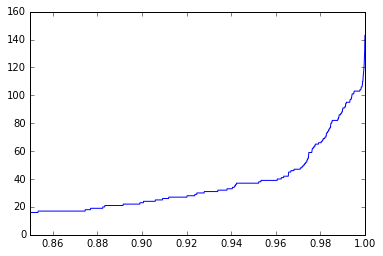

In [41]:
plot(threshold_profile['identity'], threshold_profile['subgraph_count'])
xlim(0.85, 1)

Subtracting the subgraph count from the clique count, we get the following profile:

(0.85, 1)

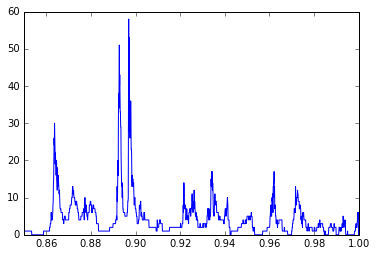

In [42]:
plot(threshold_profile['identity'], threshold_profile['clique_count']-threshold_profile['subgraph_count'])
xlim(0.85, 1)

This gives us a second way to identify natural boundaries in the data: where do the number of cliques match the number of subgraphs? That is, at which points does the plot above touch the *x*-axis? At these points, we might think that the choice of thresholds has found natural groupings of data.

We can estimate such points by plotting a histogram and noting the locations of the peaks.

(0.85, 1)

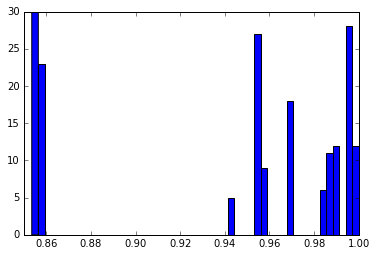

In [43]:
bounds = threshold_profile.loc[threshold_profile['clique_count']-threshold_profile['subgraph_count']==0,]
n, bins, patches = hist(bounds['identity'], bins=50)
xlim(0.85, 1)

This indicates that the regions of percentage identity at 0.850-0.855; 0.950-0.955; 0.965-0.970; 0.990-0.995 are likely to be natural boundaries.

We can inspect these, below.

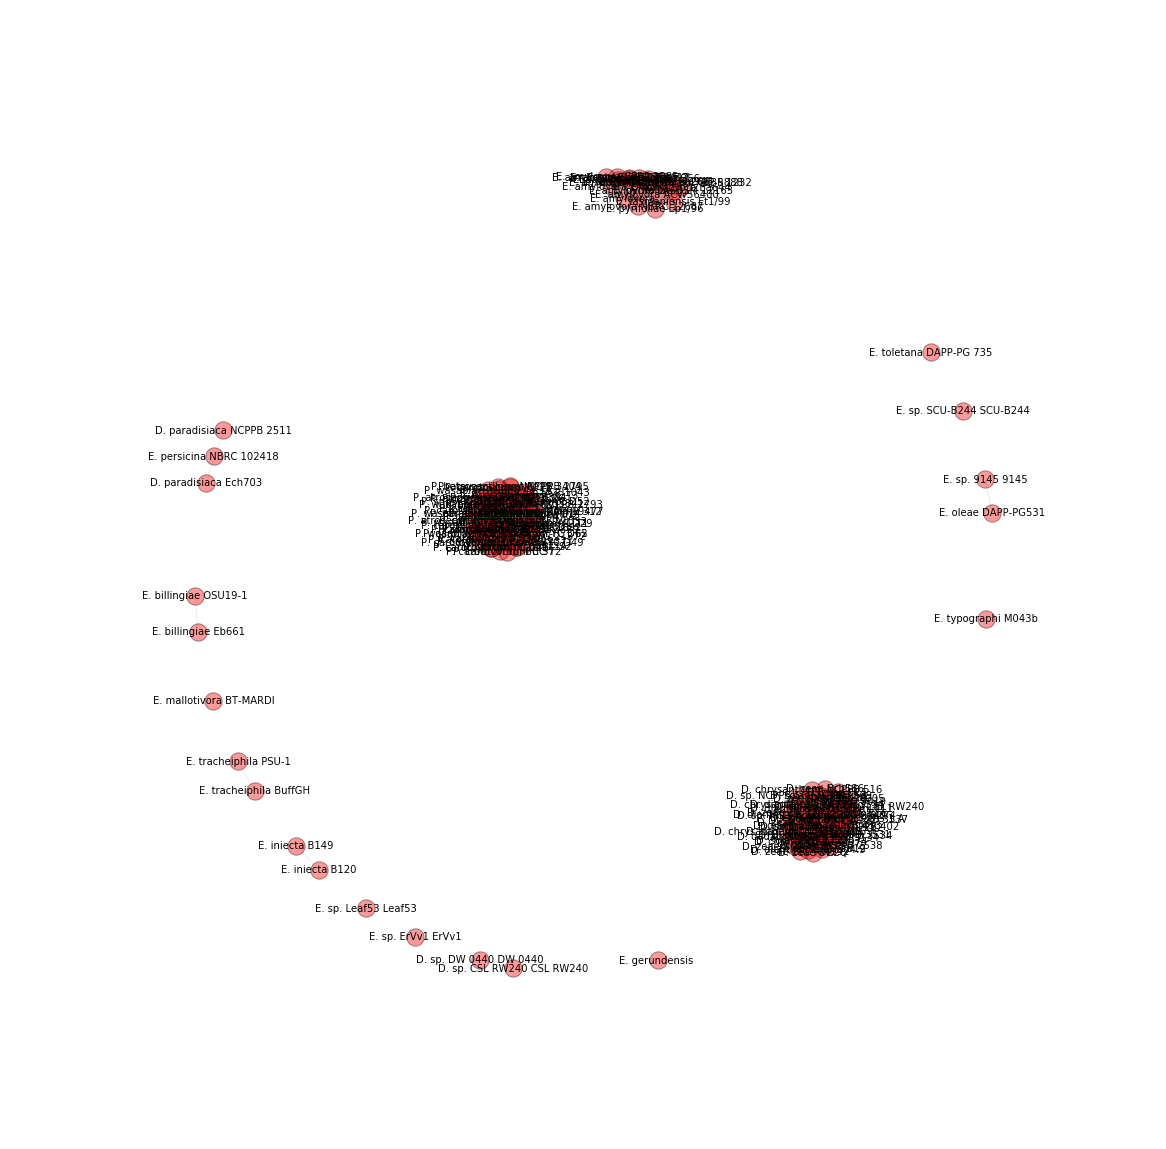

In [44]:
# Create graph
L = nx.Graph()

# Add nodes, then loop over rows in node data, adding edges
for node in node_names:
    L.add_node(node)

errs = node_data.apply(add_edge, axis=1, args=(L,), cov_thresh=0.5)

# Trim to 0.855% identity
L = trim_graph(L, 0.855)

# Draw network
draw_network(L, k=0.05)

In [45]:
print_cliques(L)

Network size: 143, Subgraphs: 17, Number of cliques: 17, Total clique size: 143
46
['D. zeae Ech586', 'D. solani GBBC 2040', 'D. dianthicola IPO 980', 'D. sp. 2B12 2B12', 'D. chrysanthemi Ech1591', 'D. dianthicola NCPPB 3534', 'D. sp. NCPPB 3274 NCPPB 3274', 'D. zeae MK19', 'D. zeae NCPPB 2538', 'D. dadantii NCPPB 2976', 'D. dadantii NCPPB 3537', 'D. zeae EC1', 'D. solani M005', 'D. dianthicola NCPPB 3534', 'D. sp. NCPPB 569 NCPPB 569', 'D. zeae DZ2Q', 'D. sp. B16 B16', 'D. solani PPO 9134', 'D. dianthicola GBBC 2039', 'D. chrysanthemi M074', 'D. zeae ZJU1202', 'D. sp. MK7 MK7', 'D. chrysanthemi NCPPB 3533', 'D. solani RNS 08.23.3.1.A', 'D. solani IFB 0099', 'D. zeae CSL RW192', 'D. dadantii 3937', 'D. solani D s0432-1', 'D. solani RNS 07.7.3B', 'D. zeae NCPPB 3531', 'D. sp. S1 S1', 'D. dianthicola NCPPB 453', 'D. dadantii NCPPB 898', 'D. solani IPO 2222', 'D. zeae MS1', 'D. chrysanthemi NCPPB 402', 'D. solani PPO 9019', 'D. solani MK16', 'D. solani RNS 05.1.2A', 'D. zeae NCPPB 3532', 

At this level of identity, we have a split into the major genus groups - with some of the smaller clusters of isolates and individual isolates also indicated as groups.

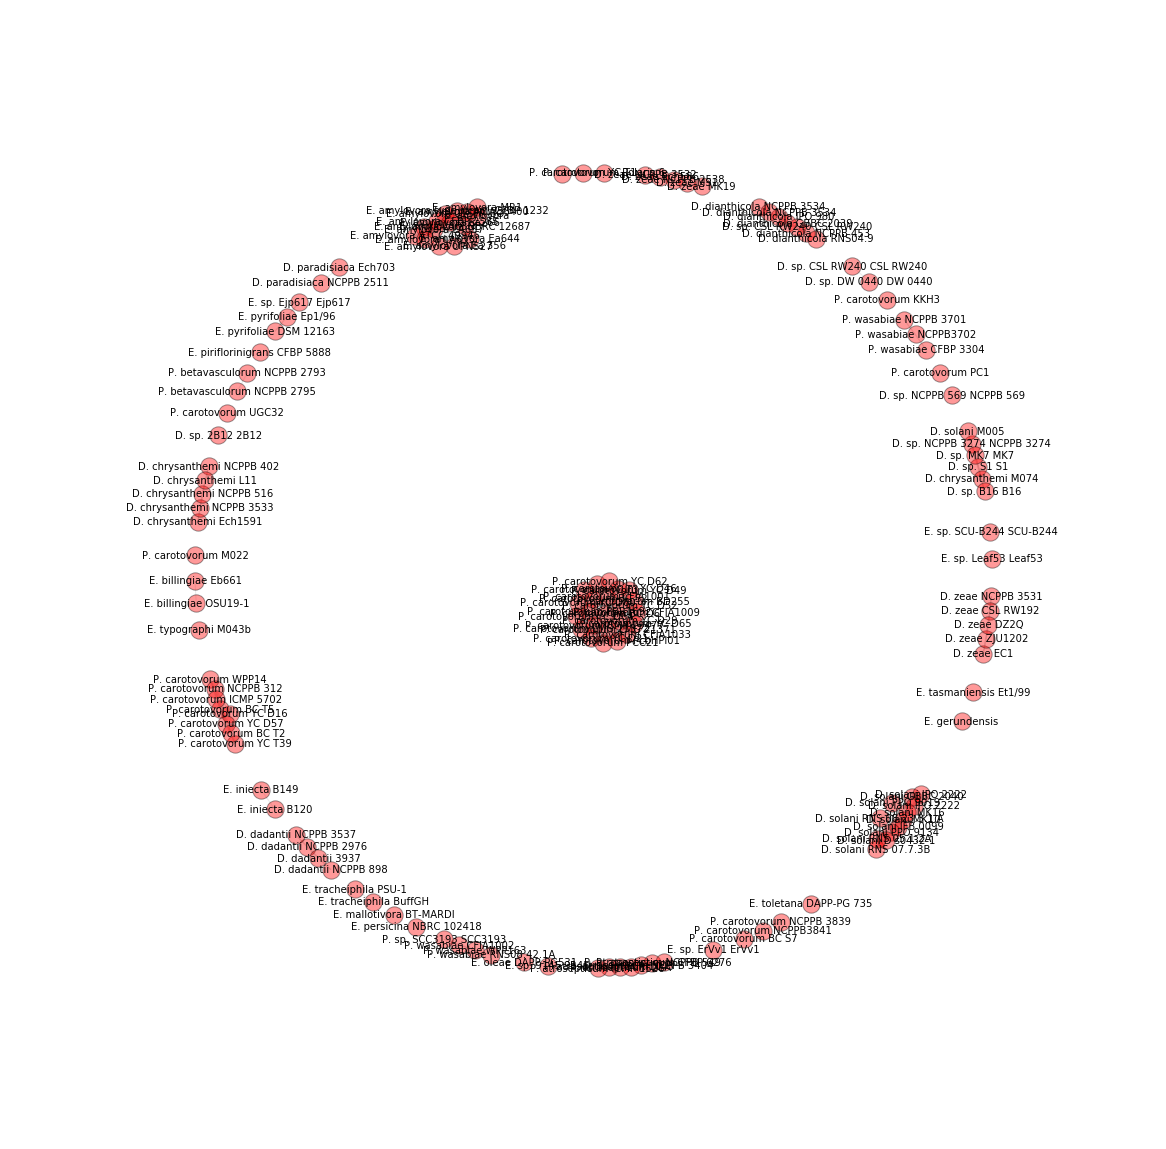

In [46]:
# Trim to 0.955% identity
L = trim_graph(L, 0.955)

# Draw network
draw_network(L, k=0.05)

In [47]:
print_cliques(L)

Network size: 143, Subgraphs: 39, Number of cliques: 39, Total clique size: 143
5
['D. zeae Ech586', 'D. zeae MS1', 'D. zeae NCPPB 3532', 'D. zeae MK19', 'D. zeae NCPPB 2538']


1
['D. sp. 2B12 2B12']


23
['P. carotovorum LMG 21371', 'P. carotovorum CFIA1033', 'P. carotovorum PBR1692', 'P. carotovorum YC T3', 'P. carotovorum YC D62', 'P. carotovorum BD255', 'P. carotovorum CFIA1001', 'P. carotovorum YC D64', 'P. carotovorum YC D60', 'P. carotovorum LMG 21372', 'P. carotovorum PCC21', 'P. carotovorum ICMP 19477', 'P. carotovorum YC D52', 'P. carotovorum YC D49', 'GCA_000808295.1_ASM80829v1_genomic', 'P. carotovorum PcbHPI01', 'P. carotovorum CFIA1009', 'P. carotovorum YC D21', 'P. carotovorum YC D29', 'P. carotovorum BC D6', 'P. carotovorum YC D65', 'P. carotovorum YC D46', 'P. carotovorum BC S2']


1
['E. mallotivora BT-MARDI']


1
['P. carotovorum PC1']


15
['E. amylovora LA636', 'E. amylovora Ea644', 'E. amylovora UPN527', 'E. amylovora ACW56400', 'E. amylovora LA637', 'E. amylovor

This level of classification closely matches the individual species as previously assigned (some necessary reclassification notwithstanding). 

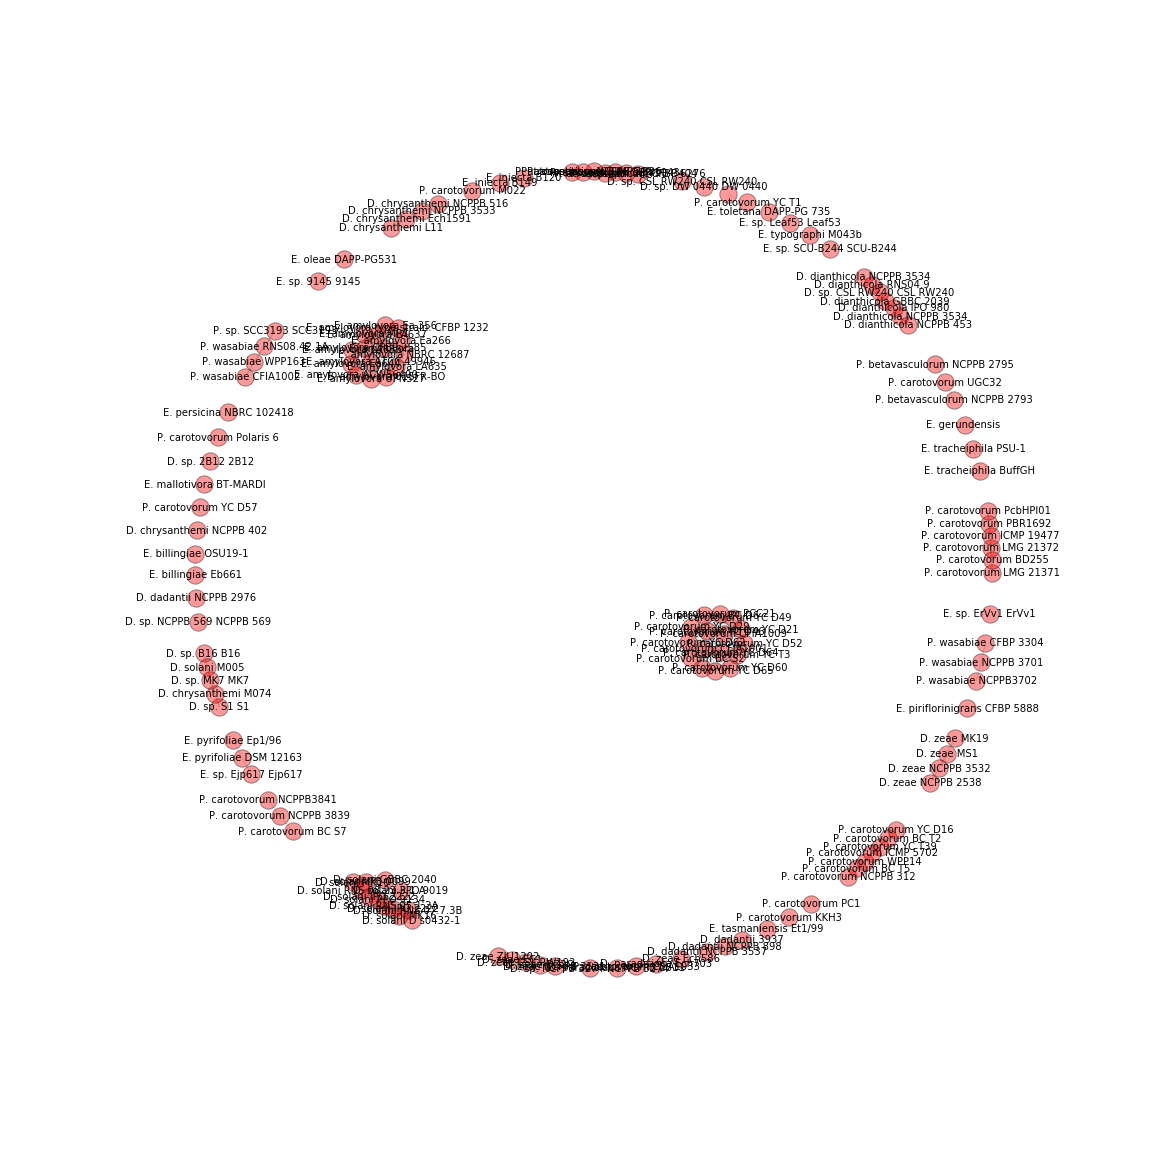

In [48]:
# Trim to 0.969% identity
L = trim_graph(L, 0.969)

# Draw network
draw_network(L, k=0.05)

In [49]:
print_cliques(L)

Network size: 143, Subgraphs: 47, Number of cliques: 47, Total clique size: 143
1
['D. zeae Ech586']


1
['D. sp. 2B12 2B12']


6
['P. carotovorum LMG 21371', 'P. carotovorum LMG 21372', 'P. carotovorum PBR1692', 'P. carotovorum ICMP 19477', 'P. carotovorum PcbHPI01', 'P. carotovorum BD255']


1
['E. mallotivora BT-MARDI']


1
['P. carotovorum PC1']


15
['E. amylovora LA636', 'E. amylovora Ea644', 'E. amylovora UPN527', 'E. amylovora ACW56400', 'E. amylovora LA637', 'E. amylovora type strain: CFBP 1232', 'E. amylovora NBRC 12687', 'E. amylovora Ea266', 'E. amylovora Ea 356', 'E. amylovora CFBP 2585', 'E. amylovora ATCC 49946', 'E. amylovora ', 'E. amylovora MR1', 'E. amylovora LA635', 'E. amylovora 01SFR-BO']


1
['D. sp. NCPPB 3274 NCPPB 3274']


7
['D. dianthicola NCPPB 3534', 'D. dianthicola IPO 980', 'D. dianthicola NCPPB 453', 'D. dianthicola GBBC 2039', 'D. dianthicola RNS04.9', 'D. dianthicola NCPPB 3534', 'D. sp. CSL RW240 CSL RW240']


4
['D. zeae MK19', 'D. zeae MS1', 'D. ze

At this more restrictive level of identity, *P. carotovorum* has been divided into 11 groupings, and other 'traditional' species-level classifications have been subdivided also (especially within *Dickeya*) 

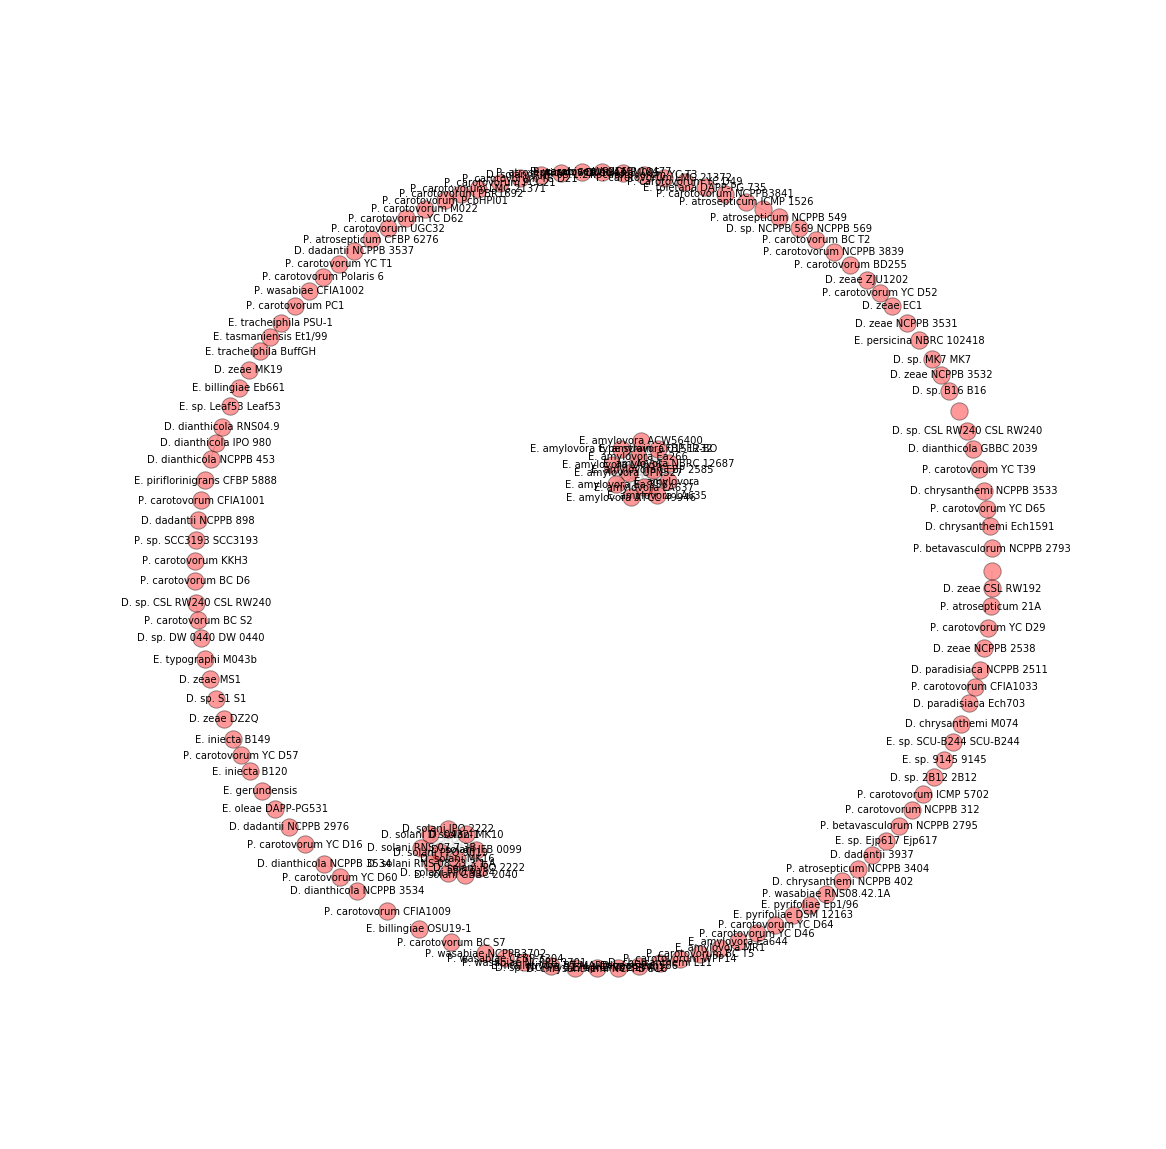

In [50]:
# Trim to 0.9945% identity
L = trim_graph(L, 0.9945)

# Draw network
draw_network(L, k=0.05)

In [51]:
print_cliques(L)

Network size: 143, Subgraphs: 101, Number of cliques: 101, Total clique size: 143
1
['D. zeae Ech586']


1
['D. sp. 2B12 2B12']


3
['P. carotovorum LMG 21371', 'P. carotovorum PBR1692', 'P. carotovorum PcbHPI01']


1
['E. mallotivora BT-MARDI']


1
['P. carotovorum PC1']


13
['E. amylovora LA636', 'E. amylovora UPN527', 'E. amylovora ACW56400', 'E. amylovora LA637', 'E. amylovora type strain: CFBP 1232', 'E. amylovora NBRC 12687', 'E. amylovora Ea266', 'E. amylovora Ea 356', 'E. amylovora ATCC 49946', 'E. amylovora ', 'E. amylovora CFBP 2585', 'E. amylovora LA635', 'E. amylovora 01SFR-BO']


1
['D. sp. NCPPB 3274 NCPPB 3274']


2
['D. dianthicola NCPPB 3534', 'D. dianthicola NCPPB 3534']


1
['D. zeae MK19']


1
['E. sp. 9145 9145']


1
['D. sp. NCPPB 569 NCPPB 569']


11
['D. solani PPO 9134', 'D. solani GBBC 2040', 'D. solani D s0432-1', 'D. solani RNS 07.7.3B', 'D. solani IPO 2222', 'D. solani PPO 9019', 'D. solani IFB 0099', 'D. solani MK16', 'D. solani MK10', 'D. solani IPO 2222

At this point, the number of cliques/subgraphs has doubled, and many isolates have been separated into single-member subgraphs. It is tempting to interpret this as being *too* fine a distinction between genomes for useful classification, but it does help highlight 'near-clonal' isolates, whose genomes are highly similar (e.g. *E. amylovora* and *D. solani*).

With this dataset, it appears that there are natural 'genus', 'species' and 'subspecies' boundaries that fall out of the data - more boundaries with different meanings may be found in more complex datasets. Rather than looking at these measures across many cross-genera isolates, it may be worth considering following the boundary analyses progressively, only within connected subgraphs.

(0, 70)

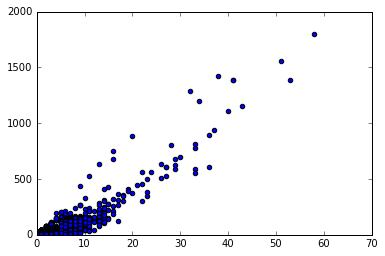

In [52]:
scatter(threshold_profile['clique_count']-threshold_profile['subgraph_count'], threshold_profile['difference'])
ylim(0, 2000)
xlim(0, 70)

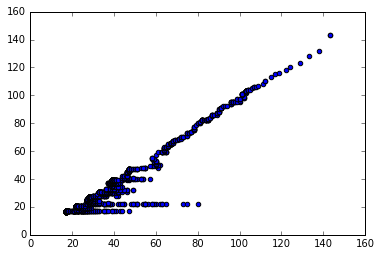

In [53]:
scatter(threshold_profile['clique_count'], threshold_profile['subgraph_count'])

In [54]:
threshold_profile.describe()

identity  network_size  subgraph_count  clique_count  \
count  1500.000000          1500     1500.000000   1500.000000   
mean      0.925000           143       37.400667     41.793333   
std       0.043345             0       23.904974     23.134925   
min       0.850000           143       16.000000     17.000000   
25%       0.887500           143       21.000000     27.000000   
50%       0.925000           143       30.000000     36.000000   
75%       0.962500           143       41.000000     47.000000   
max       1.000000           143      143.000000    143.000000   

       total_clique_size   difference  
count        1500.000000  1500.000000  
mean          207.000000    64.000000  
std           148.390246   148.390246  
min           143.000000     0.000000  
25%           148.000000     5.000000  
50%           167.000000    24.000000  
75%           206.250000    63.250000  
max          1940.000000  1797.000000

Looking at this profile, some broad features stand out (all for the SRE data).

* At large clique numbers, the isolates are well-separated into individual groupings (from the scatterplot).

* Ignoring 'spikes' there are two rates of increase in clique size: a slower rate from 85% identity to ≈97% identity (20-40 cliques), and a faster rate from 97% to 100% identity (40-140 cliques).

* The total number of cliques, and the difference between total clique size and network size is spiky, with three major spikes at 86.5, 89.3, and 89.9 %id, approximately. These represent points at which many overlapping cliques are a major feature of the data.

The difference between total clique size and input network size is mostly pretty flat (median 24 for SRE data), but notably 'spiky', three very prominent peaks, and seven or eight minor peaks.

From the scatterplot, it's clear that these spikes occur at intermediate total clique numbers.